In [118]:
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta

# Hardcoded experiments (without path prefix)
experiments = [
    "TestVnetRunnerABR/VariableAvailableCapacitySingleFlow",
    "TestVnetRunnerSimulcast/VariableAvailableCapacitySingleFlow"
]

# Base path for experiment data
base_path = "data"

config_path = "vnet/config.yaml"

In [119]:
def load_config(config_path):
    """Load the configuration file and return test cases as a dictionary."""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Convert test cases to a dictionary with name as key
    test_cases = {}
    for test_case in config.get('test_cases', []):
        if 'name' in test_case:
            test_cases[test_case['name']] = test_case
    
    return test_cases

In [120]:
def extract_path_characteristics(test_case):
    """Extract path characteristics from the test case configuration."""
    path_char = test_case.get('path_characteristic', {})
    phases = path_char.get('phases', [])
    
    if not phases:
        return None
    
    # Convert phases to a time series
    time_points = []
    capacity_points = []
    
    current_time = 0
    
    for phase in phases:
        # Extract duration in seconds
        duration_str = phase.get('duration', '0s')
        if duration_str.endswith('s'):
            duration = int(duration_str[:-1])
        else:
            duration = int(duration_str)
        
        # Extract capacity in bits per second
        capacity = phase.get('capacity', 0)
        
        # Add start point of this phase
        time_points.append(current_time)
        capacity_points.append(capacity / 1000)  # Convert to kbps
        
        # Add end point of this phase
        current_time += duration
        time_points.append(current_time)
        capacity_points.append(capacity / 1000)  # Convert to kbps
    
    return {
        'time': time_points,
        'capacity_kbps': capacity_points
    }

In [121]:
def load_experiments_data(experiments, base_path):
    """Load experiment data from log files."""
    experiment_data = {}

    for experiment in experiments:
        # Construct full path
        exp_path = Path(base_path) / experiment
        flows = {}

        for log_file in exp_path.glob("*.log"):
            parts = log_file.stem.split("_", 1)
            if len(parts) != 2:
                continue  # skip malformed names
            flow_id, log_type = parts
            flow_id = int(flow_id)

            if flow_id not in flows:
                flows[flow_id] = {}
            flows[flow_id][log_type] = log_file

        # Parse logs per flow
        experiment_data[experiment] = {}
        for flow_id, logs in flows.items():
            flow_data = {}

            if "cc" in logs:
                cc_log = pd.read_csv(logs["cc"], header=None, names=["time", "target_bitrate"])
                cc_log["time"] = pd.to_datetime(cc_log["time"], unit="ms")
                flow_data["cc_log"] = cc_log

            for side in ["sender", "receiver"]:
                for kind in ["rtp", "rtcp"]:
                    key = f"{side}_{kind}"
                    if key in logs:
                        if kind == "rtp":
                            df = pd.read_csv(logs[key], header=None, names=[
                                "time", "payload_type", "ssrc", "seq", "timestamp",
                                "marker", "size", "twcc", "unwrapped_seq"
                            ])
                            df["time"] = pd.to_datetime(df["time"], unit="ms")
                        else:
                            df = pd.read_csv(logs[key], header=None, names=["time", "size"])
                            df["time"] = pd.to_datetime(df["time"], unit="ms")
                        flow_data[key] = df

            experiment_data[experiment][flow_id] = flow_data

    return experiment_data

In [122]:
def compute_bitrates(experiment_data, window_ms=500):
    """Compute bitrates for all experiments."""
    for exp_name, flows in experiment_data.items():
        for flow_id, data in flows.items():
            if "sender_rtp" in data:
                df = data["sender_rtp"]
                df["time_bin"] = df["time"].dt.floor(f"{window_ms}ms")
                bitrate_df = df.groupby("time_bin")["size"].sum().reset_index()
                bitrate_df["bitrate_kbps"] = (bitrate_df["size"] * 8) / (window_ms / 1000) / 1000
                data["bitrate"] = bitrate_df

In [123]:
def compute_lost_packets(experiment_data):
    """Compute cumulative lost packets for all experiments."""
    for exp_name, flows in experiment_data.items():
        for flow_id, data in flows.items():
            if "receiver_rtp" in data:
                df = data["receiver_rtp"]
                
                # Calculate min unwrapped sequence number
                min_seq = df["unwrapped_seq"].min()
                
                # Calculate expected packets at each point
                df["expected_packets"] = df["unwrapped_seq"] - min_seq + 1
                
                # Calculate received packets (cumulative count)
                df["received_packets"] = np.arange(1, len(df) + 1)
                
                # Calculate lost packets
                df["lost_packets"] = df["expected_packets"] - df["received_packets"]
                
                # Store the result
                data["lost_packets"] = df[["time", "lost_packets"]]

In [124]:
def compute_interarrival_jitter(experiment_data):
    """Compute interarrival jitter according to RFC 3550.
    
    The interarrival jitter is defined as the mean deviation of the difference
    in packet spacing at the receiver compared to the sender for a pair of packets.
    
    Formula: J(i) = J(i-1) + (|D(i-1,i)| - J(i-1))/16
    where D(i-1,i) = (Ri - Ri-1) - (Si - Si-1) = (Ri - Si) - (Ri-1 - Si-1)
    
    Ri is the time of arrival in RTP timestamp units for packet i
    Si is the RTP timestamp from packet i
    """
    for exp_name, flows in experiment_data.items():
        for flow_id, data in flows.items():
            if "receiver_rtp" in data:
                df = data["receiver_rtp"]
                
                # Convert arrival time to milliseconds since first packet
                first_arrival = df["time"].min()
                df["arrival_ms"] = (df["time"] - first_arrival).dt.total_seconds() * 1000
                
                # Initialize jitter array
                jitter = np.zeros(len(df))
                
                # Calculate jitter for each packet (starting from the second one)
                for i in range(1, len(df)):
                    # Calculate D: difference in relative transit times
                    # D(i-1,i) = (Ri - Ri-1) - (Si - Si-1) = (Ri - Si) - (Ri-1 - Si-1)
                    arrival_diff = df.iloc[i]["arrival_ms"] - df.iloc[i-1]["arrival_ms"]
                    timestamp_diff = df.iloc[i]["timestamp"] - df.iloc[i-1]["timestamp"]
                    
                    # Convert timestamp diff to same units as arrival (ms)
                    # Assuming RTP timestamp is in the same timebase
                    # This is a simplification - in reality, we would need to know the clock rate
                    timestamp_diff_ms = timestamp_diff / 90  # Assuming 90kHz clock rate for video
                    
                    D = arrival_diff - timestamp_diff_ms
                    
                    # Update jitter using the formula J(i) = J(i-1) + (|D(i-1,i)| - J(i-1))/16
                    jitter[i] = jitter[i-1] + (abs(D) - jitter[i-1]) / 16
                
                # Create a DataFrame with time and jitter
                jitter_df = pd.DataFrame({
                    "time": df["time"],
                    "jitter": jitter
                })
                
                # Store the result
                data["jitter"] = jitter_df

In [125]:
def plot_experiment_results(experiment_data, path_characteristics_map):
    """Plot bitrates, path characteristics, lost packets, and jitter for all experiments."""
    for exp_name, flows in experiment_data.items():
        # Create a figure with three subplots (bitrate, lost packets, and jitter)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
        fig.suptitle(f"Experiment Results - {exp_name}", fontsize=16)
        
        # Setup first subplot for bitrate
        ax1.set_title("Bitrate Utilization")
        ax1.set_ylabel("Bitrate (kbps)")
        
        # Setup second subplot for lost packets
        ax2.set_title("Cumulative Lost Packets")
        ax2.set_ylabel("Lost Packets Count")
        
        # Setup third subplot for jitter
        ax3.set_title("Interarrival Jitter (RFC 3550)")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Jitter (ms)")
        
        colors = plt.colormaps.get_cmap('tab10').colors

        # Plot path characteristics if available for this experiment
        path_characteristics = path_characteristics_map.get(exp_name)
        if path_characteristics:
            # Get the start time from the first flow's data
            start_time = None
            for flow_id, data in flows.items():
                if "sender_rtp" in data:
                    start_time = data["sender_rtp"]["time"].min()
                    break
            
            if start_time is not None:
                # Convert seconds to datetime
                time_points = [start_time + timedelta(seconds=t) for t in path_characteristics['time']]
                ax1.plot(time_points, path_characteristics['capacity_kbps'], 
                        label="Path Capacity", color='black', linestyle='-.', linewidth=2)

        for i, (flow_id, data) in enumerate(flows.items()):
            color = colors[i % len(colors)]
            label = f"Flow {flow_id}"

            # Plot RTP bitrate on first subplot
            if "bitrate" in data:
                df = data["bitrate"]
                ax1.plot(df["time_bin"], df["bitrate_kbps"], label=f"{label} RTP",
                        color=color, linestyle='-')

            # Plot CC target on first subplot
            if "cc_log" in data:
                cc = data["cc_log"]
                ax1.plot(cc["time"], cc["target_bitrate"] / 1000, label=f"{label} Target",
                        color=color, linestyle='--')
                
            # Plot lost packets on second subplot
            if "lost_packets" in data:
                lost = data["lost_packets"]

                ax2.plot(lost["time"], lost["lost_packets"], label=f"{label} Lost Packets",
                        color=color, linestyle='-')
                
            # Plot jitter on third subplot
            if "jitter" in data:
                jitter = data["jitter"]
                ax3.plot(jitter["time"], jitter["jitter"], label=f"{label} Jitter",
                        color=color, linestyle='-')

        # Add legends
        ax1.legend()
        ax2.legend()
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

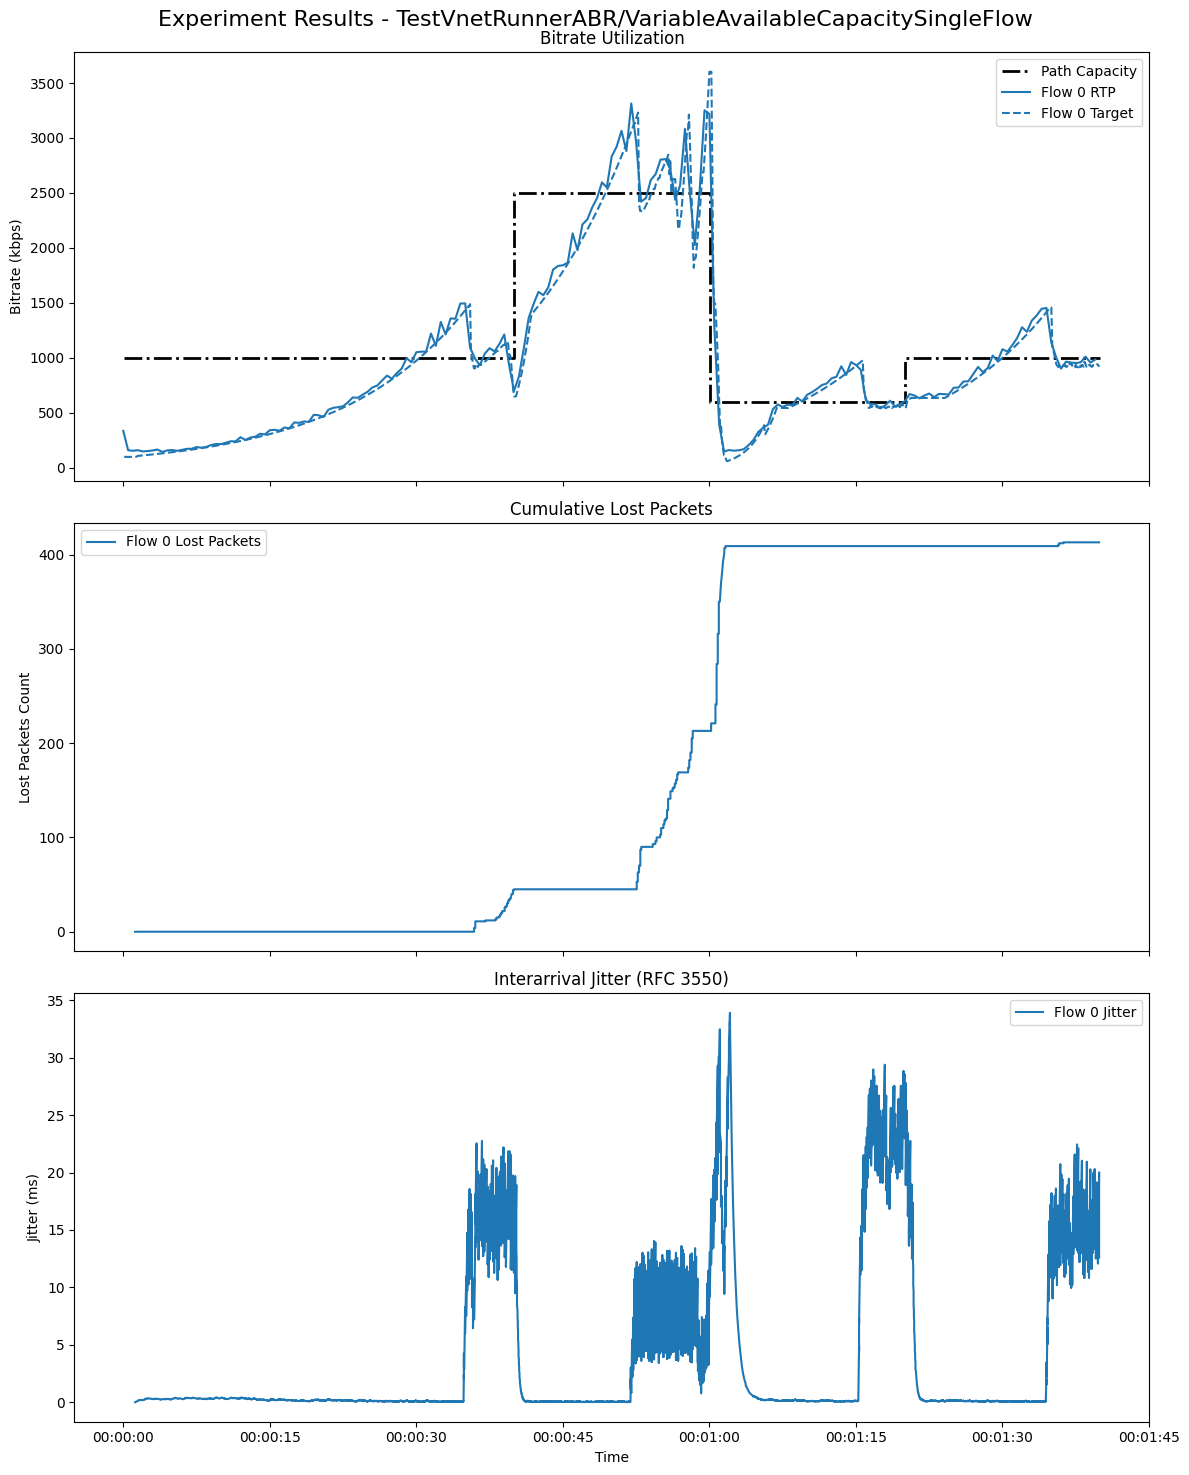

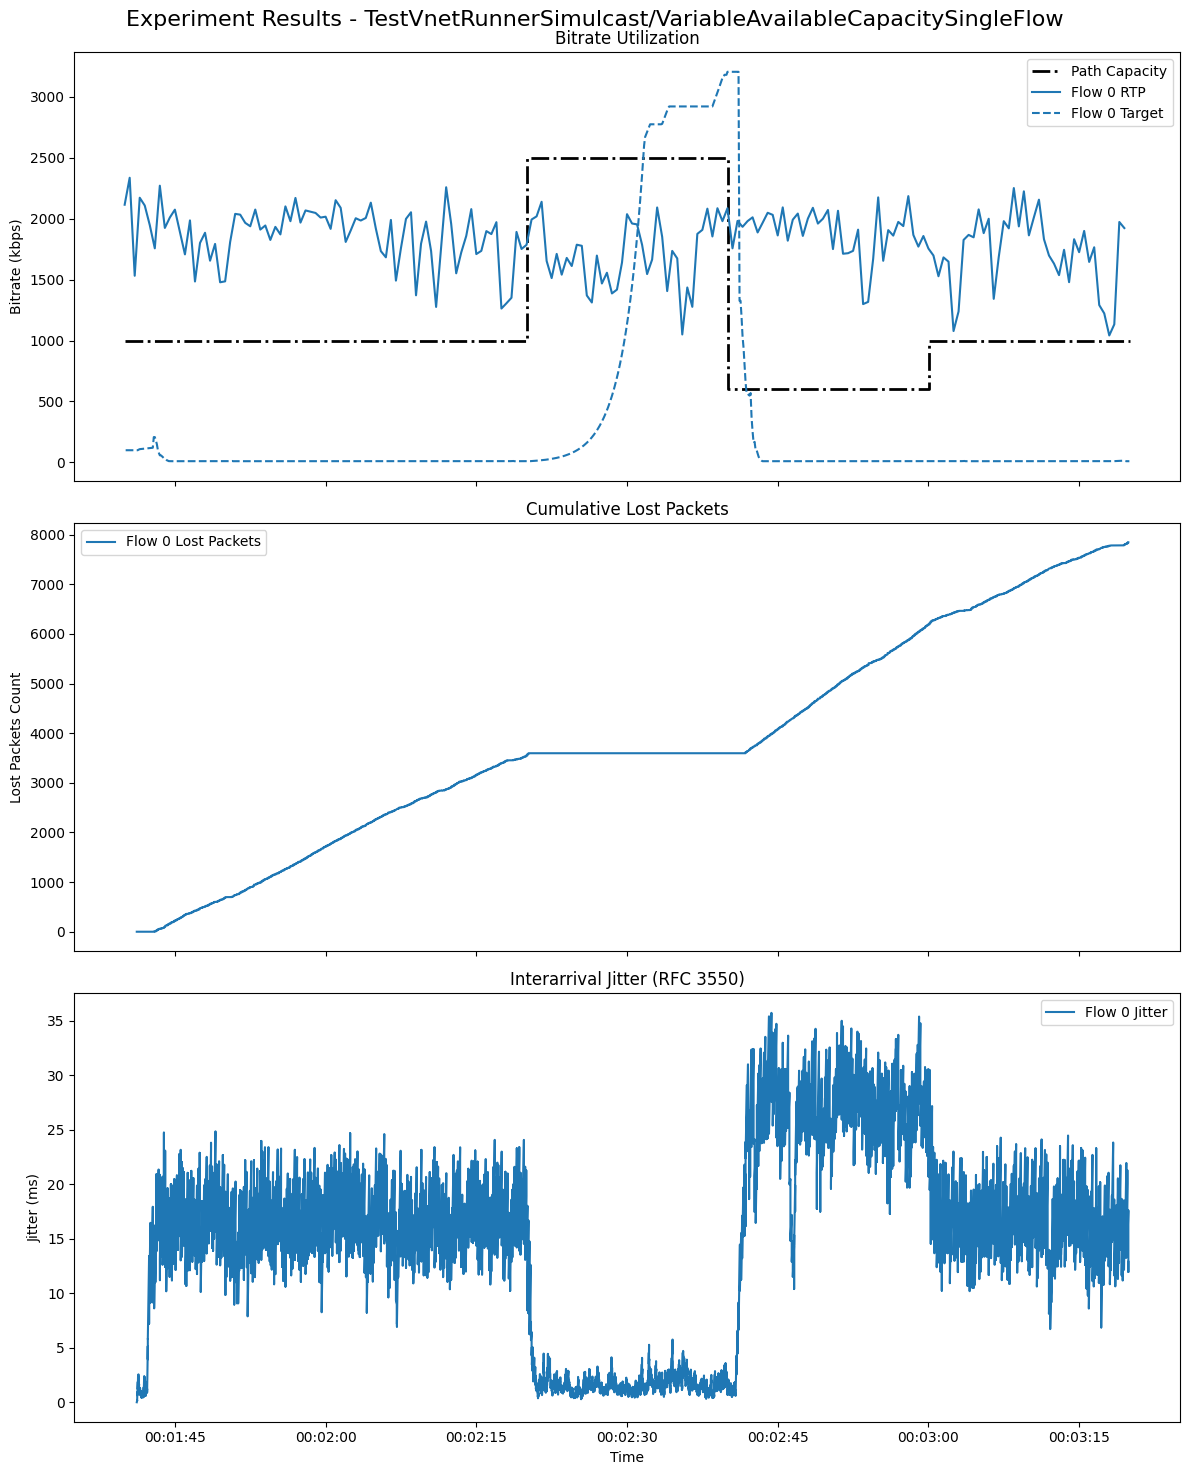

In [126]:
# Load the experiment data
experiment_data = load_experiments_data(experiments, base_path)

# Compute bitrates, lost packets, and jitter
compute_bitrates(experiment_data)
compute_lost_packets(experiment_data)
compute_interarrival_jitter(experiment_data)

# Load test cases from the configuration as a dictionary
test_cases = load_config(config_path)

# Extract path characteristics for each experiment
path_characteristics_map = {}
for experiment in experiments:
    if experiment not in test_cases:
        print(f"Warning: No test case found for experiment {experiment}. Skipping path characteristics extraction.")
        continue
    test_case = test_cases[experiment]
    path_characteristics_map[experiment] = extract_path_characteristics(test_case)

# Plot the data with path characteristics, lost packets, and jitter
plot_experiment_results(experiment_data, path_characteristics_map)